In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q git+https://github.com/qubvel/segmentation_models.pytorch
!pip install -q git+https://github.com/PyTorchLightning/pytorch-lightning
!pip install -q torchinfo

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 922.7 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.7/596.7 kB 7.4 MB/s eta 0:00:00
     ━━

In [2]:
import os
import pandas as pd
from sklearn.utils import shuffle

drive_dir = '/content/drive/MyDrive/Studia/Praca dyplomowa magisterska/'

dataset_dir = os.path.join(drive_dir, 'road-dataset/train/')

image_files = [
    os.path.join(dataset_dir, file)
    for file in os.listdir(dataset_dir)
    if file.endswith('.jpg')
]

mask_files = [
    os.path.join(dataset_dir, file)
    for file in os.listdir(dataset_dir)
    if file.endswith('.png')
]

df_dataset = pd.DataFrame({
    'images': sorted(image_files),
    'masks': sorted(mask_files)
})

df_dataset.sample()


images  \
1635  /content/drive/MyDrive/Studia/Praca dyplomowa ...   

                                                  masks  
1635  /content/drive/MyDrive/Studia/Praca dyplomowa ...

3.2.2. Zbiór danych - drogi

In [ ]:
class_dict = pd.read_csv(os.path.join(drive_dir, 'road-dataset/class_dict.csv'))

class_names = class_dict['name']
class_rgb_values = class_dict[['r', 'g', 'b']].values

print('Class names:', class_names.tolist())
print('Class RGB values:', class_rgb_values.tolist())

Class names: ['road', 'background']
Class RGB values: [[255, 255, 255], [0, 0, 0]]


In [ ]:
from sklearn.model_selection import train_test_split

df_train_dataset, df_val_dataset = train_test_split(df_dataset, test_size=0.3, random_state=0)
df_val_dataset, df_test_dataset = train_test_split(df_val_dataset, test_size=0.5, random_state=0)

print('Train dataset size:', len(df_train_dataset))
print('Validation dataset size:', len(df_val_dataset))
print('Test dataset size:', len(df_test_dataset))

Train dataset size: 4358
Validation dataset size: 934
Test dataset size: 934


3.3.1. Augmentacja

In [ ]:
image_size = 512

In [ ]:
import albumentations as album

def get_training_augmentation():
    train_transform = [
        album.Resize(image_size, image_size),
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5),
        album.RandomBrightnessContrast(p=0.4),
    ]
    return album.Compose(train_transform)

def get_validation_augmentation():
    val_transform = [
        album.Resize(image_size, image_size),
        album.RandomBrightnessContrast(p=0.4)
    ]
    return album.Compose(val_transform)

In [ ]:
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np

def visualize_dataset(dataset, visualize_augmentation=False):
    i = random.choice(dataset.index)

    image_path = dataset['images'].loc[i]
    mask_path = dataset['masks'].loc[i]

    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2RGB)

    num_subplots = 3 if visualize_augmentation else 4
    width_ratios = [1] * num_subplots if visualize_augmentation else [1, 1, 1, 0.05]

    fig, axes = plt.subplots(1, num_subplots, figsize=(4 * num_subplots, 4), gridspec_kw={'width_ratios': width_ratios})

    axes[0].set_title('Image')
    axes[0].imshow(image)

    axes[1].set_title('Mask')
    axes[1].imshow(mask)

    if visualize_augmentation:
        augmentation = get_training_augmentation()
        augmented_dataset = RoadDataset(dataset, augmentation=augmentation)
        augmented_image, augmented_mask = augmented_dataset[i]

        axes[2].set_title('Augmented image')
        axes[2].imshow(augmented_image)

    else:
        category_labels = mask_to_category_labels(mask)

        axes[2].set_title('Category labels')
        im = axes[2].imshow(category_labels)

        cbar = fig.colorbar(im, ax=axes[2], ticks=np.arange(len(class_dict)), cax=axes[3])
        cbar.ax.set_yticklabels(class_dict['name'])

    plt.tight_layout()
    plt.show()

3.3.2. Konwersja masek do etykiet kategorii

In [ ]:
def mask_to_category_labels(mask):
    class_dict_arr = class_dict[['r', 'g', 'b']].values.astype(np.uint8)
    matches = np.all(mask == class_dict_arr[:, None, None], axis=-1)
    indices = np.argmax(matches, axis=0)
    category_labels = np.zeros(mask.shape[:2], dtype=np.int8)
    category_labels[matches.any(axis=0)] = indices[matches.any(axis=0)]

    return category_labels

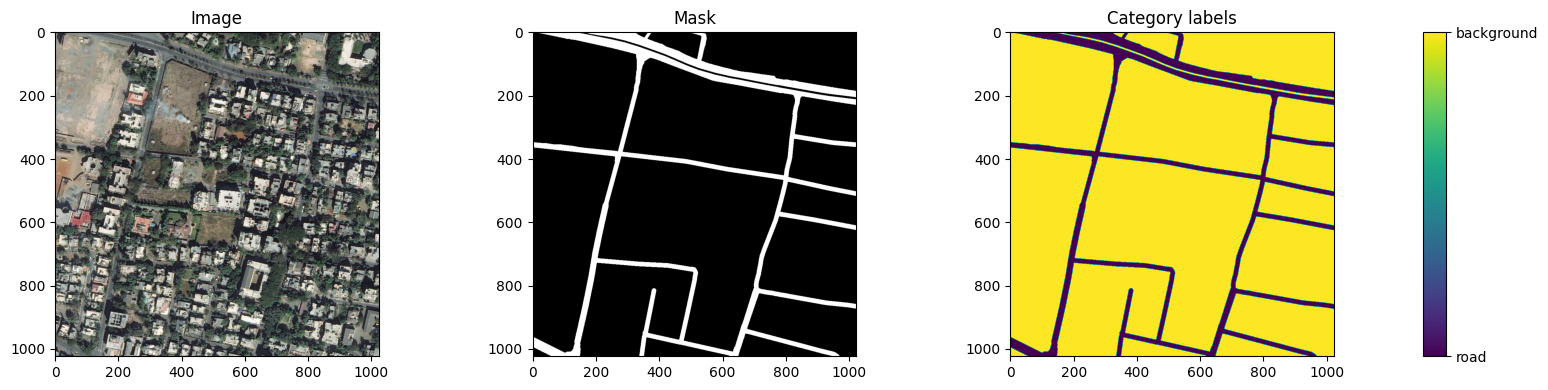

In [ ]:
visualize_dataset(df_dataset)

3.3.3. Przetwarzanie wstępne

In [ ]:
import torch

def image_to_tensor(image, **kwargs):
    image = np.transpose(image, (2, 0, 1)).astype(np.float64)
    image = torch.Tensor(image) / 255.0

    return image

def mask_to_tensor(mask, **kwargs):
    mask = np.expand_dims(mask, axis=0)
    mask = torch.Tensor(mask).long()

    return mask

def get_processing():
    transform = []
    transform.append(album.Lambda(image=image_to_tensor, mask=mask_to_tensor))

    return album.Compose(transform)

In [ ]:
from torch.utils.data import Dataset, DataLoader

class RoadDataset(Dataset):
    def __init__(self, df_dataset, augmentation=None, preprocessing=None):
        self.df_dataset = df_dataset
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, idx):
        row = self.df_dataset.iloc[idx]
        image = cv2.cvtColor(cv2.imread(row['images']), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(row['masks']), cv2.COLOR_BGR2RGB)

        if self.augmentation:
            augmented = self.augmentation(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']

        mask = mask_to_category_labels(mask)

        if self.preprocessing:
            preprocessed = self.preprocessing(image=image, mask=mask)
            image, mask = preprocessed['image'], preprocessed['mask']

        return image, mask

    def __len__(self):
        return len(self.df_dataset)

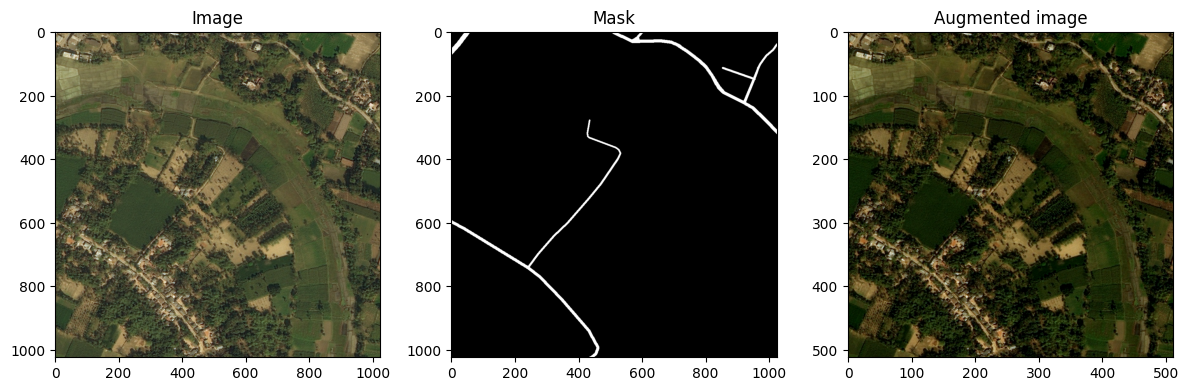

In [ ]:
visualize_dataset(df_dataset, True)

In [ ]:
train_dataset = RoadDataset(df_train_dataset,
                            augmentation=get_training_augmentation(),
                            preprocessing=get_processing())
val_dataset = RoadDataset(df_val_dataset,
                          augmentation=get_validation_augmentation(),
                          preprocessing=get_processing())
test_dataset = RoadDataset(df_test_dataset,
                          augmentation=get_validation_augmentation(),
                          preprocessing=get_processing())

In [ ]:
batch_size = 12

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=12)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=12)

3.3.4. Podsumowanie

In [ ]:
image, mask = next(iter(train_dataloader))
image.shape, mask.shape

(torch.Size([12, 3, 512, 512]), torch.Size([12, 1, 512, 512]))

3.4.1. Inicjalizacja modelu \\
3.4.2. Funkcja straty i metryki \\
3.4.3. Metoda propagacji w przód \\
3.4.4. Konfiguracja optymalizatora \\
3.4.5. Przebieg procesu

In [ ]:
from segmentation_models_pytorch import Unet
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.metrics import get_stats, accuracy, iou_score, precision, recall, f1_score
import torch.optim as optim
import torch.nn as nn
import pytorch_lightning as pl

class RoadModel(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        self.model = Unet(
            encoder_name='efficientnet-b7',
            encoder_weights='imagenet',
            in_channels=3,
            classes=num_classes,
            activation='sigmoid'
        )
        self.criterion = DiceLoss(mode="multiclass", from_logits=False, classes=list(range(num_classes)))
        self.metrics = {
            'accuracy': accuracy,
            'iou': iou_score,
            'precision': precision,
            'recall': recall,
            'f1score': f1_score
        }
        self.num_classes = num_classes
        self.true_classes = []
        self.pred_classes = []

    def forward(self, inputs, targets=None):
        outputs = self.model(inputs)
        if targets is not None:
            loss = self.criterion(outputs, targets)
            tp, fp, fn, tn = get_stats(outputs.argmax(dim=1).unsqueeze(1).type(torch.int64), targets, mode='multiclass', num_classes=self.num_classes)
            metrics = {
                key: metric(tp, fp, fn, tn, reduction='micro-imagewise')
                for key, metric in self.metrics.items()
            }
            return loss, metrics, outputs
        else:
            return outputs

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.0001)

    def shared_step(self, batch, batch_idx, prefix):
        images, masks = batch
        loss, metrics, outputs = self(images, masks)
        if prefix == 'test':
            self.true_classes.append(masks.flatten().cpu().numpy())
            self.pred_classes.append(outputs.argmax(dim=1).flatten().cpu().numpy())
        log_dict = {f'{prefix}_loss': loss}
        log_dict.update({f'{prefix}_{k}': v for k, v in metrics.items()})
        self.log_dict(log_dict, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, batch_idx, 'train')

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, batch_idx, 'val')

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, batch_idx, 'test')


3.4.6. Podsumowanie

In [ ]:
from torchinfo import summary

model = RoadModel(len(class_names))
summary(model, input_size=(batch_size, 3, image_size, image_size))

Layer (type:depth-idx)                                       Output Shape              Param #
RoadModel                                                    [12, 2, 512, 512]         --
├─Unet: 1-1                                                  [12, 2, 512, 512]         --
│    └─EfficientNetEncoder: 2-1                              [12, 3, 512, 512]         1,643,520
│    │    └─Conv2dStaticSamePadding: 3-1                     [12, 64, 256, 256]        1,728
│    │    └─BatchNorm2d: 3-2                                 [12, 64, 256, 256]        128
│    │    └─MemoryEfficientSwish: 3-3                        [12, 64, 256, 256]        --
│    │    └─ModuleList: 3-4                                  --                        62,141,584
│    └─UnetDecoder: 2-2                                      [12, 16, 512, 512]        --
│    │    └─Identity: 3-5                                    [12, 640, 16, 16]         --
│    │    └─ModuleList: 3-6                                  --             

3.6. Trening i walidacja

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min'
)

checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    filename='roadmodel-{epoch:02d}-{val_loss:.4f}',
    monitor='val_loss',
    mode='min'
)
logger_dir = os.path.join(drive_dir, 'metrics')
logger = CSVLogger(logger_dir)

trainer = Trainer(
    accelerator="gpu",
    max_epochs=100,
    callbacks=[early_stop_callback, checkpoint_callback],
    logger=logger,
    log_every_n_steps=1,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_dataloader, val_dataloader)
trainer.test(model, test_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type     | Params
---------------------------------------
0 | model     | Unet     | 67.1 M
1 | criterion | DiceLoss | 0     
---------------------------------------
67.1 M    Trainable params
0         Non-trainable params
67.1 M    Total params
268.382   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9818322658538818     │
│       test_f1score        │    0.9818322658538818     │
│         test_iou          │    0.9649091362953186     │
│         test_loss         │    0.1114482432603836     │
│      test_precision       │    0.9818322658538818     │
│        test_recall        │    0.9818322658538818     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.1114482432603836,
  'test_accuracy': 0.9818322658538818,
  'test_iou': 0.9649091362953186,
  'test_precision': 0.9818322658538818,
  'test_recall': 0.9818322658538818,
  'test_f1score': 0.9818322658538818}]

In [ ]:
model_dir = os.path.join(drive_dir, 'road-model.pth')
torch.save(model.state_dict(), model_dir)

In [ ]:
model_dir = os.path.join(drive_dir, 'road-model.pth')
model.load_state_dict(torch.load(model_dir))

<All keys matched successfully>

4.1. Testowanie

In [ ]:
trainer.test(model, test_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9818226099014282     │
│       test_f1score        │    0.9818226099014282     │
│         test_iou          │    0.9648899435997009     │
│         test_loss         │    0.11162186414003372    │
│      test_precision       │    0.9818226099014282     │
│        test_recall        │    0.9818226099014282     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.11162186414003372,
  'test_accuracy': 0.9818226099014282,
  'test_iou': 0.9648899435997009,
  'test_precision': 0.9818226099014282,
  'test_recall': 0.9818226099014282,
  'test_f1score': 0.9818226099014282}]

3.6. Trening i walidacja

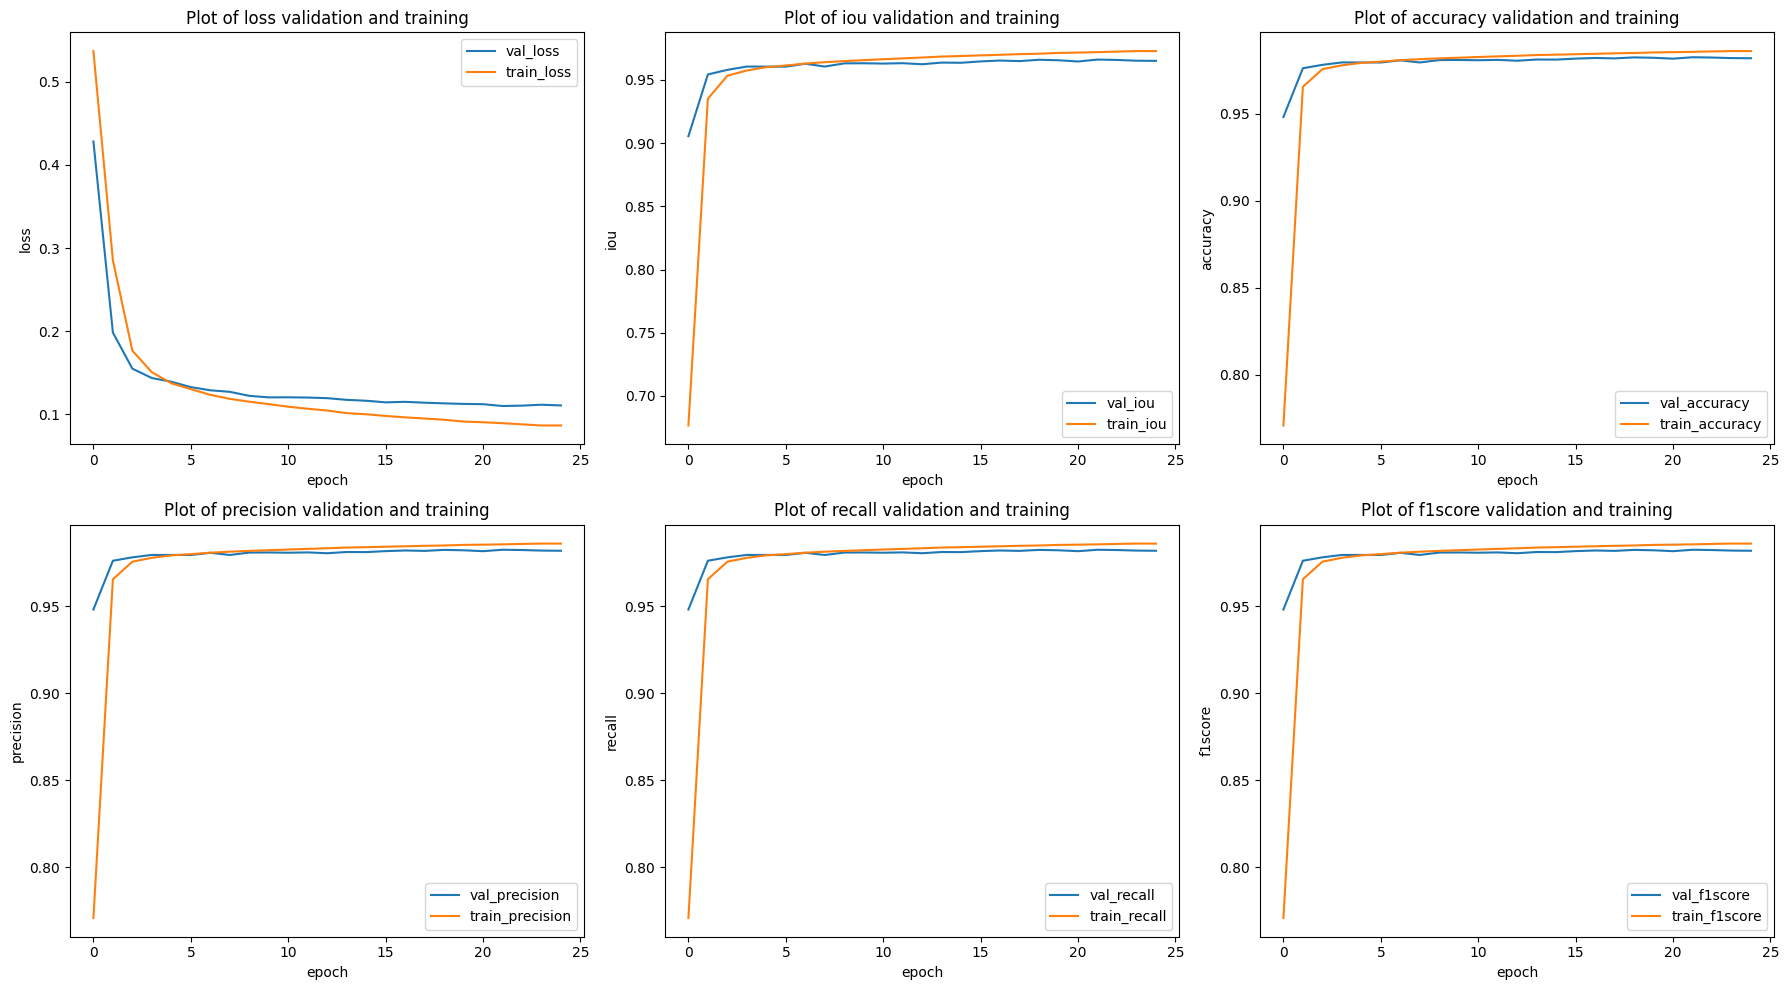

In [ ]:
def plot_metric(df, metric_name, ax):
    df = df.set_index('epoch')

    ax.plot(df[f'val_{metric_name}'].dropna(), label=f'val_{metric_name}')
    ax.plot(df[f'train_{metric_name}'].dropna(), label=f'train_{metric_name}')

    ax.set_title(f'Plot of {metric_name} validation and training')
    ax.set_xlabel('epoch')
    ax.set_ylabel(metric_name)
    ax.legend()

metrics_dir = os.path.join(drive_dir, 'metrics/lightning_logs/version_46/metrics.csv')
df = pd.read_csv(metrics_dir)

metric_names = ['loss', 'iou', 'accuracy', 'precision', 'recall', 'f1score']

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 10))
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

for axis, metric_name in zip(axes, metric_names):
    plot_metric(df, metric_name, axis)

plt.tight_layout()
plt.show()


In [ ]:
def category_labels_to_mask(category_labels):
    class_dict_arr = class_dict[['r', 'g', 'b']].values.astype(np.uint8)
    mask = class_dict_arr[category_labels]

    return mask

4.2. Przewidywane maski

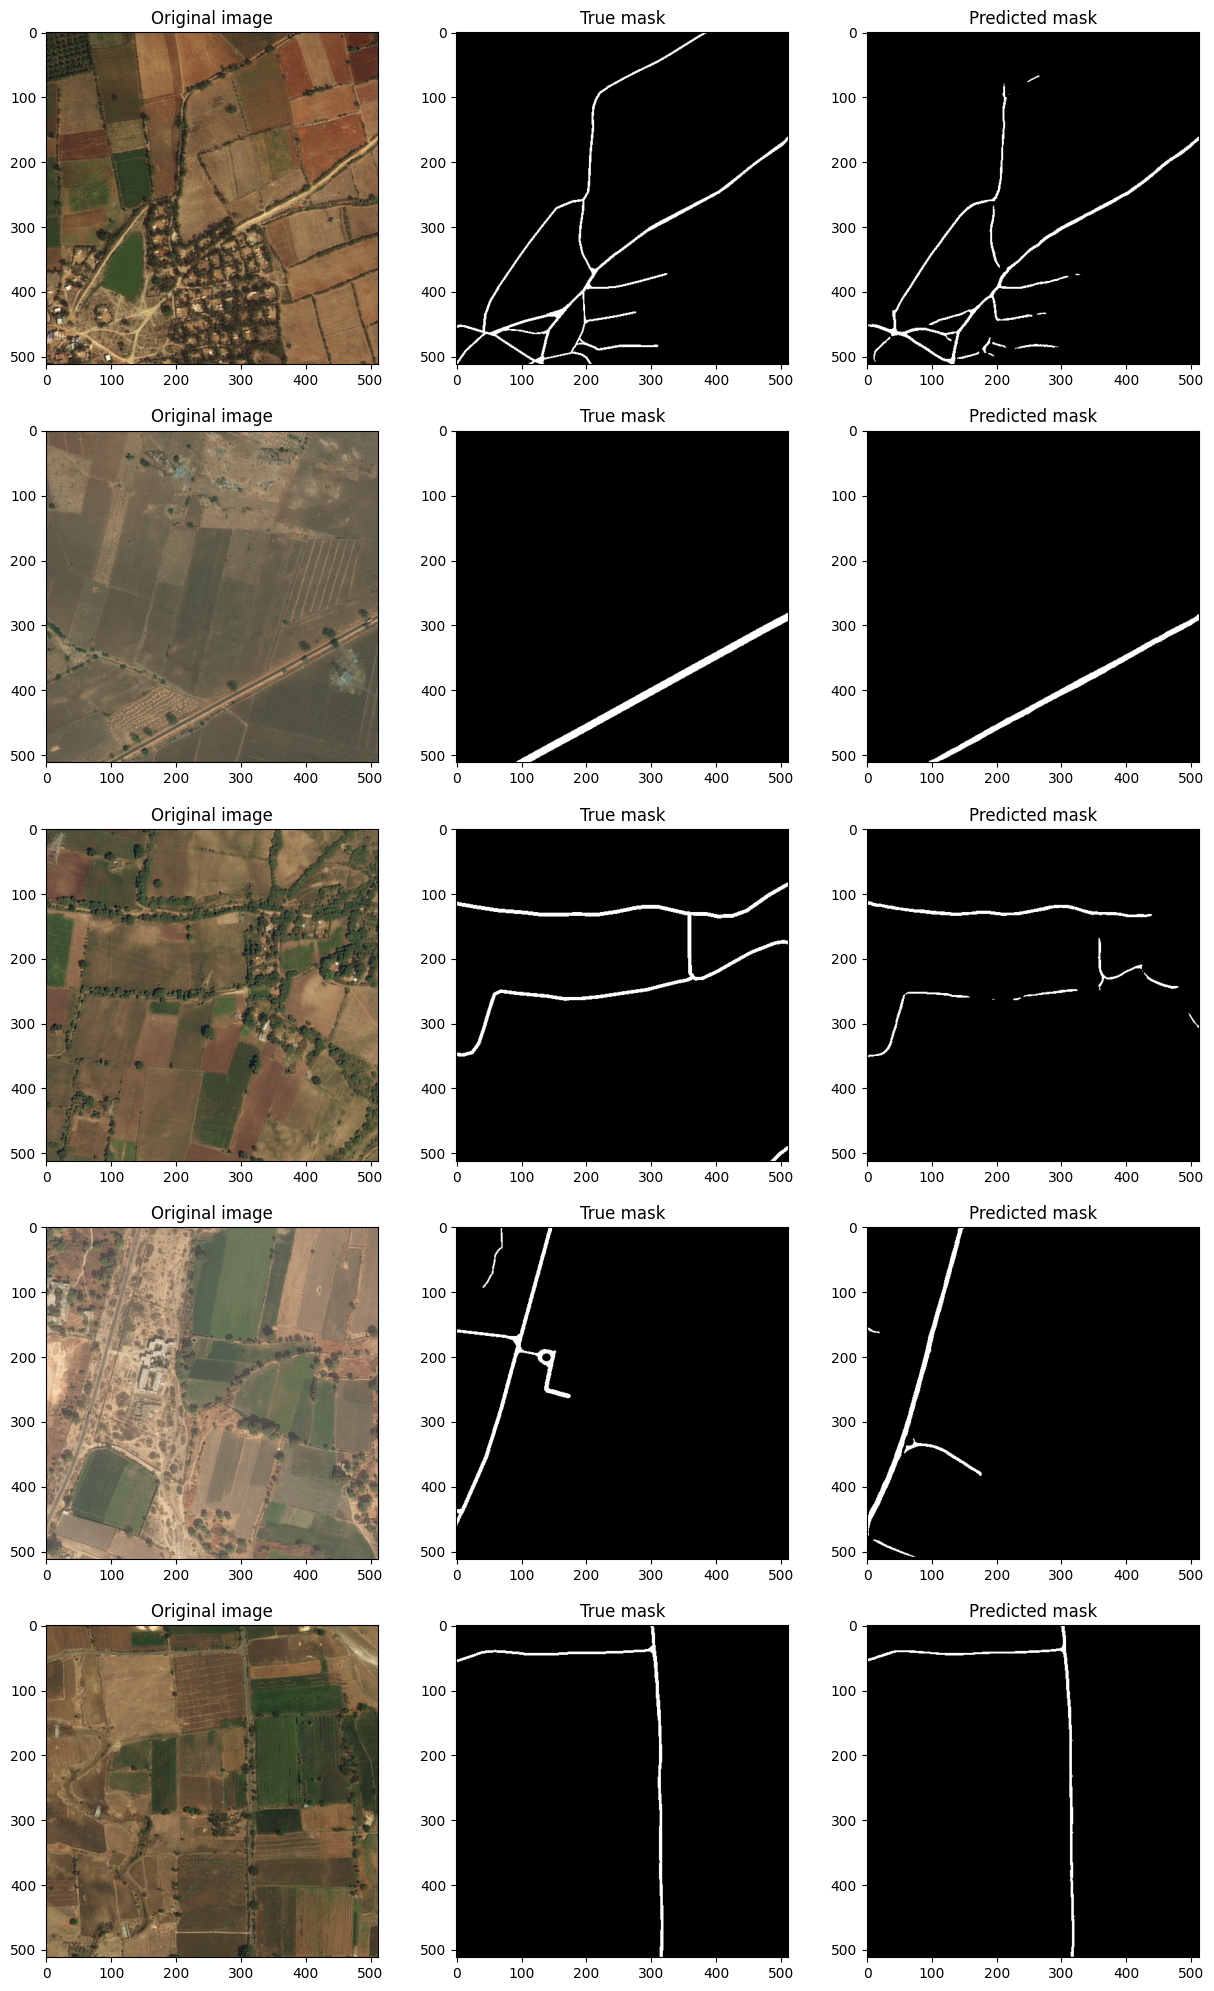

In [ ]:
def plot_predicted_masks(images, true_masks, predicted_masks, num_images=5):
    fig, axs = plt.subplots(num_images, 3, figsize=(15, 5 * num_images))

    for idx, (img, true_mask, pred_mask) in enumerate(zip(images, true_masks, predicted_masks)):
        if idx >= num_images:
            break

        img = img.permute(1, 2, 0).cpu().numpy()
        true_mask = category_labels_to_mask(true_mask.squeeze(0).cpu().numpy())
        pred_mask = category_labels_to_mask(torch.argmax(pred_mask, dim=0).cpu().numpy())

        axs[idx, 0].imshow(img)
        axs[idx, 0].set_title('Original image')

        axs[idx, 1].imshow(true_mask)
        axs[idx, 1].set_title('True mask')

        axs[idx, 2].imshow(pred_mask)
        axs[idx, 2].set_title('Predicted mask')

    plt.show()

test_images, test_masks = next(iter(test_dataloader))
predicted_masks = model(test_images)
plot_predicted_masks(test_images, test_masks, predicted_masks)


4.3. Macierze pomyłek

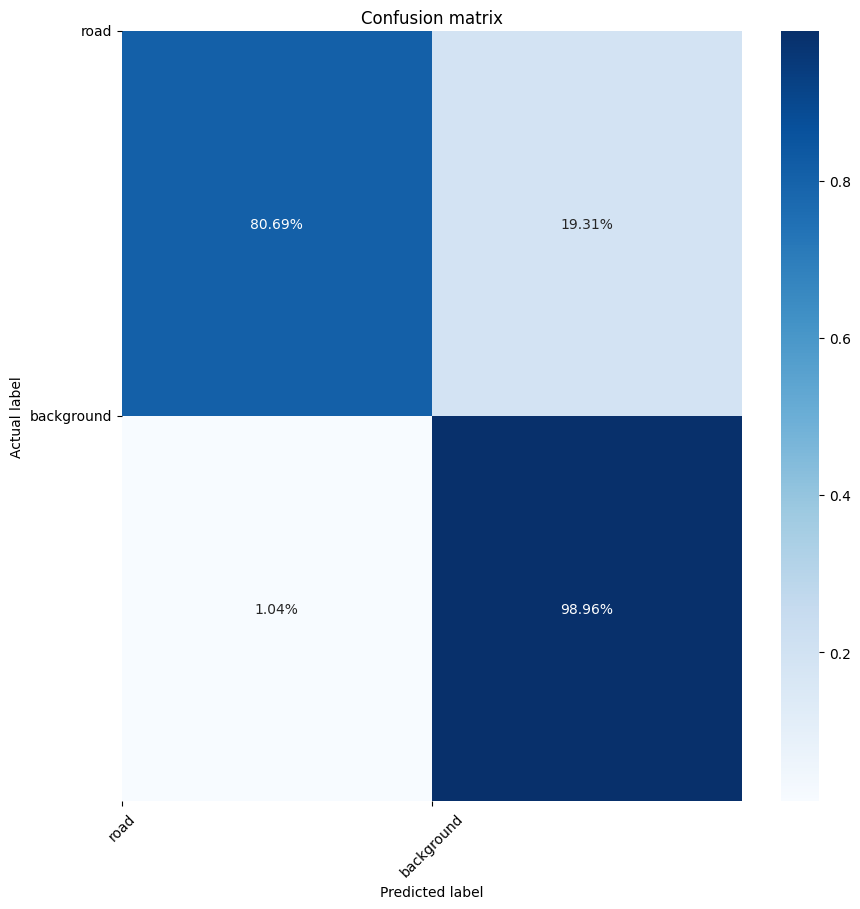

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

true_classes = np.concatenate(model.true_classes)
pred_classes = np.concatenate(model.pred_classes)

cm = confusion_matrix(true_classes, pred_classes)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.xticks(np.arange(len(class_names.tolist())), class_names.tolist(), rotation=45)
plt.yticks(np.arange(len(class_names.tolist())), class_names.tolist(), rotation=0)

plt.show()


4.4. Wektoryzacja

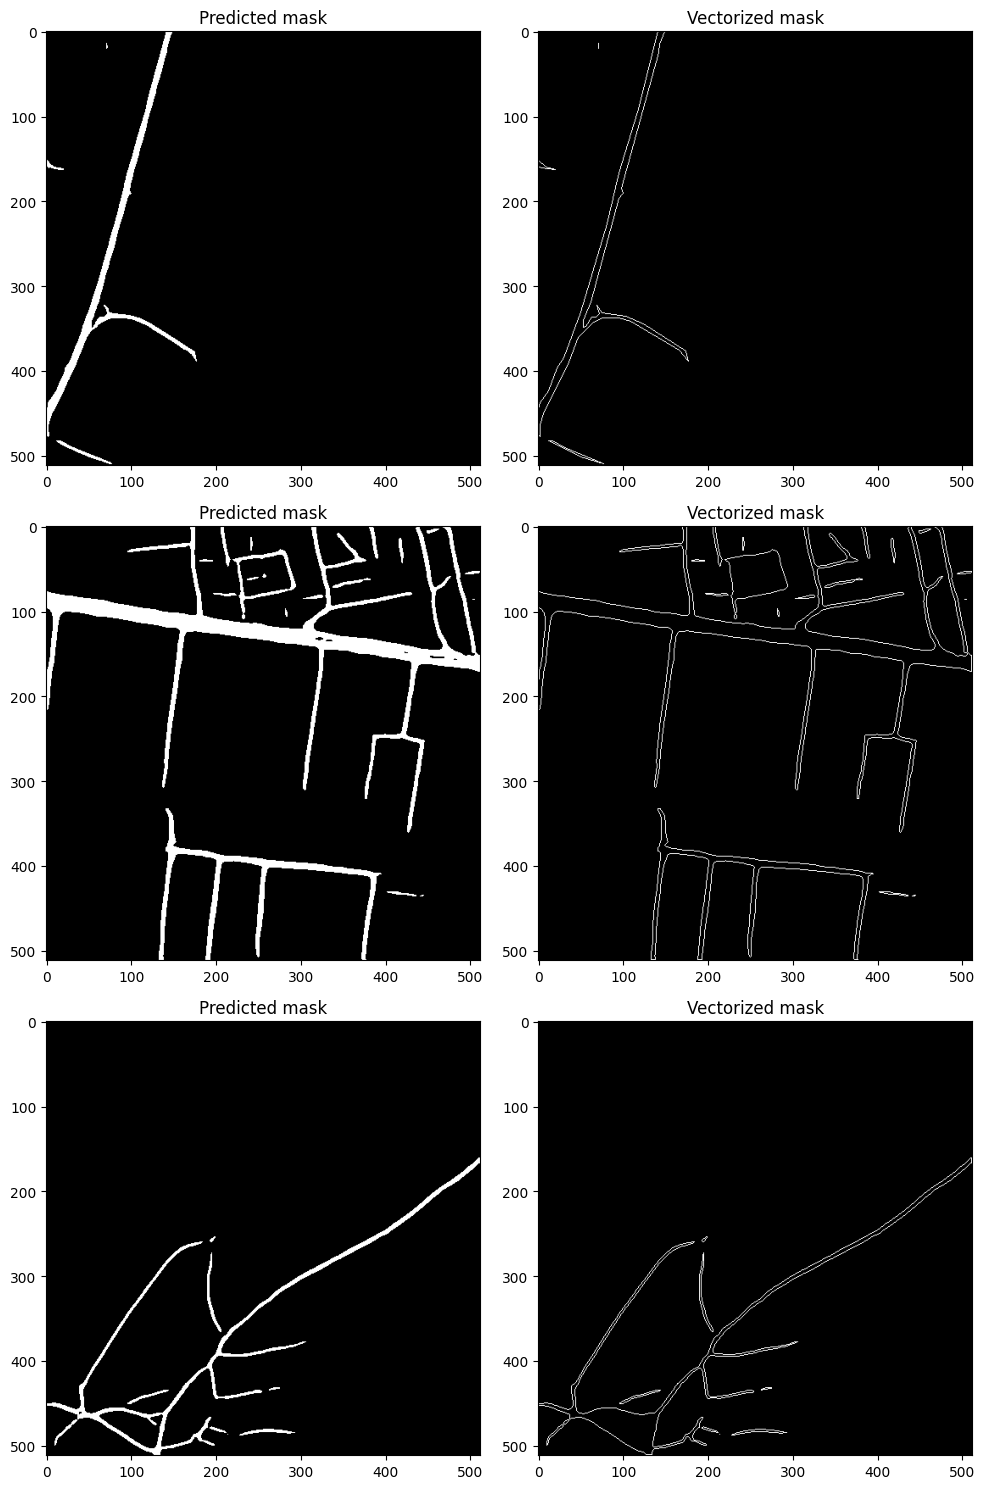

In [5]:
import cv2
import numpy as np
import random
import sqlite3
import matplotlib.pyplot as plt

def save_vectorized_mask_to_db(mask_path, db_connection, output_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    epsilon = 0.01 * cv2.arcLength(contours[0], True)
    polygons = [cv2.approxPolyDP(contour, epsilon, closed=True) for contour in contours]

    contour_mask = np.zeros_like(mask)
    cv2.drawContours(contour_mask, polygons, -1, (255, 255, 255), 1)

    cv2.imwrite(output_path, contour_mask)

    flattened_mask = contour_mask.flatten()

    cursor = db_connection.cursor()
    cursor.execute("INSERT INTO masks (mask_vector) VALUES (?)", (flattened_mask,))
    db_connection.commit()

mask_dir = os.path.join(drive_dir, 'road-sample/')
vectorized_dir = os.path.join(drive_dir, 'road-vectorized/')
db_dir = os.path.join(drive_dir, 'road_masks.db')

db_connection = sqlite3.connect(db_dir)
cursor = db_connection.cursor()
cursor.execute("CREATE TABLE IF NOT EXISTS masks (mask_vector BLOB)")
db_connection.commit()

mask_files = [file for file in os.listdir(mask_dir) if file.startswith("predicted_mask_") and file.endswith(".png")]

for mask_file in mask_files:
    mask_path = os.path.join(mask_dir, mask_file)
    output_path = os.path.join(vectorized_dir, mask_file)
    save_vectorized_mask_to_db(mask_path, db_connection, output_path)

db_connection.close()

random_masks = random.sample(mask_files, 3)

plt.figure(figsize=(10, 15))
for i, mask_file in enumerate(random_masks):
    mask_path = os.path.join(mask_dir, mask_file)
    vectorized_mask_path = os.path.join(vectorized_dir, mask_file)

    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    vectorized_mask = cv2.imread(vectorized_mask_path, cv2.IMREAD_COLOR)

    plt.subplot(3, 2, i * 2 + 1)
    plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted mask")

    plt.subplot(3, 2, i * 2 + 2)
    plt.imshow(cv2.cvtColor(vectorized_mask, cv2.COLOR_BGR2RGB))
    plt.title(f"Vectorized mask")

plt.tight_layout()
plt.show()


In [6]:
import sqlite3

db_dir = os.path.join(drive_dir, 'road_masks.db')
db_connection = sqlite3.connect(db_dir)

cursor = db_connection.cursor()

cursor.execute("SELECT mask_vector FROM masks")
mask_vectors = cursor.fetchall()

db_connection.close()
mask_vectors[2]

(b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\

In [ ]:
!nvidia-smi

Wed Jun 28 20:42:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    52W / 400W |   1209MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import cv2

save_dir = os.path.join(drive_dir, 'road-sample')

def save_predicted_masks(images, true_masks, predicted_masks, num_images):
    os.makedirs(save_dir, exist_ok=True)

    for idx, (img, true_mask, pred_mask) in enumerate(zip(images, true_masks, predicted_masks)):
        if idx >= num_images:
            break

        img = img.permute(1, 2, 0).cpu().numpy()
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


        true_mask = category_labels_to_mask(true_mask.squeeze(0).cpu().numpy())
        pred_mask = category_labels_to_mask(torch.argmax(pred_mask, dim=0).cpu().numpy())

        cv2.imwrite(os.path.join(save_dir, f'original_{idx}.jpg'), img)
        cv2.imwrite(os.path.join(save_dir, f'true_mask_{idx}.png'), true_mask)
        cv2.imwrite(os.path.join(save_dir, f'predicted_mask_{idx}.png'), pred_mask)

# test_images, test_masks = next(iter(test_dataloader))
# predicted_masks = model(test_images)
save_predicted_masks(test_images, test_masks, predicted_masks, num_images=10)
